<a href="https://colab.research.google.com/github/JustinasLekavicius/VilniusUniversity/blob/main/DeepLearningLabTask2_JustinasLekavicius.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Justinas Lekavičius, Deep Learning Lab Task 2
#Task Formulation
The second task is to implement an image classification model. 

*   [ X ] The dataset must be split into training and testing sets. You must use your own architecture, and not a pre-trained model. 
*   [ X ]  The following metrics need to be computed with the testing dataset: confusion matrix, accuracy, precision, recall and F1. Conduct threshold sensitivity analysis.
*   [ X ]  Classes are at your discretion, but there must be at least 3 classes. Data size 1000 images. 
*   [ X ]   Provide at least 3 experiments with different architectures, hyper parameters, optimizers, etc.  
*   [ X ] During the defense, the tutor will send you test images to demonstrate how your model works. During the defense, you will have to be able to explain how your model is implemented. 

The software solution is at your discretion. 

Note: create training and test set loss/accuracy visualization, check sigmoid vs softmax, cross entropy vs binary cross entropy, conduct experiments (architectures, parameters), 

In [318]:
pip install openimages

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Imports**

In [319]:
import os
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import numpy as np
from skimage import io
from skimage.color import gray2rgb
from skimage.transform import resize
import glob
import PIL
import matplotlib.pyplot as plt
from openimages.download import download_dataset
from torchvision.models import resnet50, ResNet50_Weights
from sklearn.metrics import  confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import tensorflow as tf

**Samples and classes**

In [320]:
samples = 1000
data_directory = "task2Data"

if not os.path.exists(data_directory):
    os.makedirs(data_directory)
    
class_names = ["Desk", "Camera", "Duck"] # random classes to download
#Is GPU used?
!nvidia-smi

Wed May 17 16:15:10 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0    25W /  70W |   7497MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Downloading the class images

In [321]:
print("Downloading the class data...")
download_dataset(data_directory, class_names, limit=samples)

100%|██████████| 1000/1000 [00:59<00:00, 16.81it/s]


{'desk': {'images_dir': 'task2Data/desk/images'},
 'camera': {'images_dir': 'task2Data/camera/images'},
 'duck': {'images_dir': 'task2Data/duck/images'}}

Model architecture: 2 convolutional layers, maxpool to reduce image dimensions and relu function for each layer.

In [322]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.layer2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, 3)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [323]:
def read_img(file_name, train_mode=False):
    img = io.imread(file_name)

    if img.ndim == 2:
        img = gray2rgb(img)

    if train_mode == True:
      transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Resize((64,64)),
      transforms.RandomRotation(degrees=15),
      transforms.RandomHorizontalFlip(),])
    else:

      transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Resize((224,224)),])
    
    img = transform(img)
    img = img.unsqueeze(0)

    return img.float()

In [324]:
# creation of Custom dataset

class CustomDataset(Dataset):

    def __init__(self, images_dir, custom=False, train_mode=False):
        self.images_dir = images_dir
        self.custom = custom
        self.train_mode = train_mode
        if self.custom == False:
          self.class1_files = glob.glob(self.images_dir + "/{}/images/*.jpg".format(class_names[0].lower()))
          self.class2_files = glob.glob(self.images_dir + "/{}/images/*.jpg".format(class_names[1].lower()))
          self.class3_files = glob.glob(self.images_dir + "/{}/images/*.jpg".format(class_names[2].lower()))

          self.class1 = len(self.class1_files)
          self.class2 = len(self.class2_files)
          self.class3 = len(self.class3_files)
        
          self.files = self.class1_files + self.class2_files + self.class3_files

          self.labels = np.zeros(len(self.files))
          self.labels[:self.class1] = 0
          self.labels[self.class1:self.class1+self.class2] = 1
          self.labels[self.class1+self.class2:] = 2

          self.order =  [x for x in np.random.permutation(len(self.labels))]
          self.files = [self.files[x] for x in self.order]
          self.labels = [self.labels[x] for x in self.order]
        if self.custom == True:
          self.files = glob.glob(self.images_dir + "/*.jpg")

    def __len__(self):
        if self.custom == False:
          return (len(self.labels))
        if self.custom == True:
          return (len(self.files))

    def __getitem__(self, i):

        files = self.files[i]
        im = read_img(files, self.train_mode)[0]
        img = np.array(im.numpy())
        if self.custom == False:
          y = self.labels[i]
          return (img, y)
        if self.custom == True:
          return img

train_dataset = CustomDataset(data_directory, train_mode=True)
test_dataset = CustomDataset(data_directory, train_mode=False)

Using GPU if it's available and transfering model to it

In [325]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Showing some train dataset images to see that they're read correctly

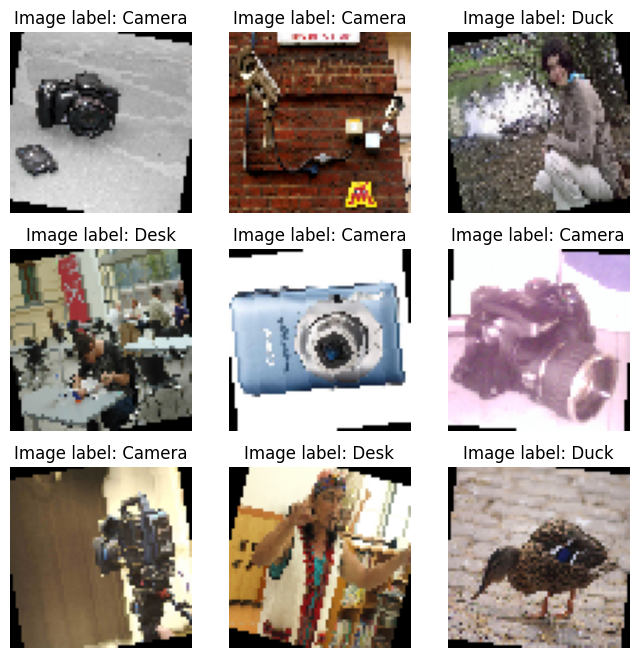

In [326]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    img = torch.tensor(img)
    image_label = label
    figure.add_subplot(rows, cols, i, title=f"Image label: {class_names[int(image_label)]}")
    img = img.numpy().transpose((1, 2, 0))
    img = np.clip(img, 0, 1)
    plt.axis("off")
    plt.imshow(img, cmap="gray")
plt.show()

Showing some test dataset images to see that they're read correctly as well

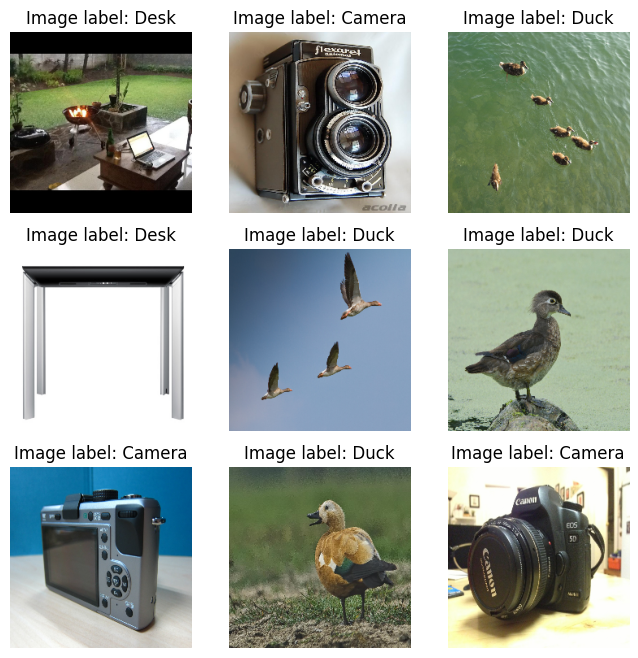

In [327]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(test_dataset), size=(1,)).item()
    img, label = test_dataset[sample_idx]
    img = torch.tensor(img)
    image_label = label
    figure.add_subplot(rows, cols, i, title=f"Image label: {class_names[int(image_label)]}")
    img = img.numpy().transpose((1, 2, 0))
    img = np.clip(img, 0, 1)
    plt.axis("off")
    plt.imshow(img, cmap="gray")
plt.show()

Splitting into train and test

In [328]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
test_size = 0.2
train_indices, test_indices = train_test_split(list(range(len(train_dataset))), test_size=test_size, random_state=RANDOM_SEED)
batch_size=64

train_data = torch.utils.data.Subset(train_dataset, train_indices)
test_data = torch.utils.data.Subset(test_dataset, test_indices)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [329]:
def train(model, optimizer, criterion, train_loader, test_loader, num_epochs):
    for epoch in range(num_epochs):
        train_loss = 0.0
        train_accuracy = 0.0
        test_loss = 0.0
        test_accuracy = 0.0
        for data in train_loader:
            inputs, labels = data
            labels = labels.type(torch.LongTensor)
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, torch.nn.functional.one_hot(labels, num_classes=3).float())

            train_loss += loss.item() * inputs.size(0)
            predicted = torch.argmax(outputs, 1)
            train_accuracy += torch.sum((labels == predicted).float())

            loss.backward()
            optimizer.step()

        with torch.no_grad():
            for data in test_loader:
                inputs, labels = data
                labels = labels.type(torch.LongTensor)
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, torch.nn.functional.one_hot(labels, num_classes=3).float())
                test_loss += loss.item() * inputs.size(0)
                predicted = torch.argmax(outputs, 1)
                test_accuracy += torch.sum((labels == predicted).float())


        print('Epoch: {} out of {} : Train loss: {:.6f}, train accuracy: {:.3f} %, test loss: {:.6f}, test accuracy: {:.3f} %'.format(
            epoch + 1, 
            num_epochs,
            train_loss / len(train_data),
            100 * (train_accuracy / len(train_data)),
            test_loss / len(test_data),
            100 * (test_accuracy / len(test_data)),
            ))

Training model BCEWithLogitsLoss and Adam optimizer.

In [330]:
model1 = Model()
model1.to(device);

criterion = nn.BCEWithLogitsLoss().to(device)
optimizer = torch.optim.Adam(model1.parameters(),
                             lr=0.1)
num_epochs = 10

train(model1, optimizer, criterion, train_loader, test_loader, num_epochs)

Epoch: 1 out of 10 : Train loss: 1.071066, train accuracy: 33.750 %, test loss: 0.639128, test accuracy: 32.167 %
Epoch: 2 out of 10 : Train loss: 0.638828, train accuracy: 32.167 %, test loss: 0.638286, test accuracy: 32.167 %
Epoch: 3 out of 10 : Train loss: 0.638374, train accuracy: 33.208 %, test loss: 0.637236, test accuracy: 32.167 %
Epoch: 4 out of 10 : Train loss: 0.638681, train accuracy: 34.750 %, test loss: 0.638649, test accuracy: 33.667 %
Epoch: 5 out of 10 : Train loss: 0.637354, train accuracy: 32.750 %, test loss: 0.641952, test accuracy: 32.167 %
Epoch: 6 out of 10 : Train loss: 0.639068, train accuracy: 33.667 %, test loss: 0.637165, test accuracy: 33.667 %
Epoch: 7 out of 10 : Train loss: 0.637860, train accuracy: 33.292 %, test loss: 0.636627, test accuracy: 34.167 %
Epoch: 8 out of 10 : Train loss: 0.638266, train accuracy: 34.125 %, test loss: 0.636576, test accuracy: 33.667 %
Epoch: 9 out of 10 : Train loss: 0.638472, train accuracy: 33.250 %, test loss: 0.637447

Adjusting learning rate for the model.

In [331]:
model2 = Model()
model2.to(device);

criterion = nn.BCEWithLogitsLoss().to(device)
optimizer = torch.optim.Adam(model2.parameters(),
                             lr=0.01)
num_epochs = 10

train(model2, optimizer, criterion, train_loader, test_loader, num_epochs)

Epoch: 1 out of 10 : Train loss: 0.618626, train accuracy: 41.792 %, test loss: 0.573438, test accuracy: 49.333 %
Epoch: 2 out of 10 : Train loss: 0.551886, train accuracy: 54.833 %, test loss: 0.510128, test accuracy: 59.167 %
Epoch: 3 out of 10 : Train loss: 0.535079, train accuracy: 56.208 %, test loss: 0.513502, test accuracy: 57.667 %
Epoch: 4 out of 10 : Train loss: 0.503947, train accuracy: 61.125 %, test loss: 0.670071, test accuracy: 46.000 %
Epoch: 5 out of 10 : Train loss: 0.513079, train accuracy: 58.917 %, test loss: 0.541410, test accuracy: 51.833 %
Epoch: 6 out of 10 : Train loss: 0.485338, train accuracy: 64.000 %, test loss: 0.544542, test accuracy: 55.000 %
Epoch: 7 out of 10 : Train loss: 0.488561, train accuracy: 62.958 %, test loss: 0.511815, test accuracy: 59.333 %
Epoch: 8 out of 10 : Train loss: 0.490129, train accuracy: 61.167 %, test loss: 0.651120, test accuracy: 47.667 %
Epoch: 9 out of 10 : Train loss: 0.476086, train accuracy: 63.917 %, test loss: 0.565827

Enhancing the model with additional layers.

In [332]:
model3 = Model()

model3.layer3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
model3.bn3 = nn.BatchNorm2d(128)
model3.relu3 = nn.ReLU()
model3.layer4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
model3.bn4 = nn.BatchNorm2d(256)
model3.relu4 = nn.ReLU()
model3.dropout = nn.Dropout(p=0.5)
model3.fc1 = nn.Linear(256, 128)
model3.fc2 = nn.Linear(128, 3)

def forward(self, x):
    x = self.relu(self.layer1(x))
    x = self.relu(self.layer2(x))
    x = self.avgpool(x)
    x = self.relu3(self.bn3(self.layer3(x)))
    x = self.relu4(self.bn4(self.layer4(x)))
    x = x.view(x.size(0), -1)
    x = self.dropout(x)
    x = self.fc1(x)
    x = self.dropout(x)
    x = self.fc2(x)
    return x

model3.forward = forward.__get__(model3)

model3.to(device);

criterion = nn.BCEWithLogitsLoss().to(device)
optimizer = torch.optim.Adam(model3.parameters(),
                             lr=0.01)
num_epochs = 10

train(model3, optimizer, criterion, train_loader, test_loader, num_epochs)

Epoch: 1 out of 10 : Train loss: 0.614046, train accuracy: 50.917 %, test loss: 0.510770, test accuracy: 64.500 %
Epoch: 2 out of 10 : Train loss: 0.523969, train accuracy: 63.708 %, test loss: 0.500577, test accuracy: 63.333 %
Epoch: 3 out of 10 : Train loss: 0.482555, train accuracy: 65.958 %, test loss: 0.479760, test accuracy: 66.833 %
Epoch: 4 out of 10 : Train loss: 0.477460, train accuracy: 66.542 %, test loss: 0.496297, test accuracy: 65.667 %
Epoch: 5 out of 10 : Train loss: 0.454019, train accuracy: 69.125 %, test loss: 0.505526, test accuracy: 61.667 %
Epoch: 6 out of 10 : Train loss: 0.450106, train accuracy: 70.792 %, test loss: 0.484990, test accuracy: 66.000 %
Epoch: 7 out of 10 : Train loss: 0.425288, train accuracy: 71.958 %, test loss: 0.517447, test accuracy: 63.333 %
Epoch: 8 out of 10 : Train loss: 0.429263, train accuracy: 72.375 %, test loss: 0.549822, test accuracy: 60.667 %
Epoch: 9 out of 10 : Train loss: 0.432541, train accuracy: 70.333 %, test loss: 0.506085

Changing to SGD optimizer, adding weight decay (L2 regularization) and increasing the number of epochs. 

In [333]:
model4 = Model()

model4.layer3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
model4.bn3 = nn.BatchNorm2d(128)
model4.relu3 = nn.ReLU()
model4.layer4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
model4.bn4 = nn.BatchNorm2d(256)
model4.relu4 = nn.ReLU()
model4.dropout = nn.Dropout(p=0.5)
model4.fc1 = nn.Linear(256, 128)
model4.fc2 = nn.Linear(128, 3)

def forward(self, x):
    x = self.relu(self.layer1(x))
    x = self.relu(self.layer2(x))
    x = self.avgpool(x)
    x = self.relu3(self.bn3(self.layer3(x)))
    x = self.relu4(self.bn4(self.layer4(x)))
    x = x.view(x.size(0), -1)
    x = self.dropout(x)
    x = self.fc1(x)
    x = self.dropout(x)
    x = self.fc2(x)
    return x

model4.forward = forward.__get__(model4)

model4.to(device);

criterion = nn.BCEWithLogitsLoss().to(device)
optimizer = torch.optim.SGD(model4.parameters(),
                             lr=0.01, momentum=0.9, weight_decay=0.001)
num_epochs = 50

train(model4, optimizer, criterion, train_loader, test_loader, num_epochs)

Epoch: 1 out of 50 : Train loss: 0.580648, train accuracy: 53.583 %, test loss: 0.501807, test accuracy: 60.833 %
Epoch: 2 out of 50 : Train loss: 0.491273, train accuracy: 64.000 %, test loss: 0.484291, test accuracy: 63.000 %
Epoch: 3 out of 50 : Train loss: 0.471511, train accuracy: 65.333 %, test loss: 0.465598, test accuracy: 65.333 %
Epoch: 4 out of 50 : Train loss: 0.464600, train accuracy: 66.917 %, test loss: 0.459169, test accuracy: 65.667 %
Epoch: 5 out of 50 : Train loss: 0.443911, train accuracy: 69.000 %, test loss: 0.430143, test accuracy: 68.667 %
Epoch: 6 out of 50 : Train loss: 0.431872, train accuracy: 69.083 %, test loss: 0.442658, test accuracy: 67.667 %
Epoch: 7 out of 50 : Train loss: 0.440681, train accuracy: 68.792 %, test loss: 0.438568, test accuracy: 69.667 %
Epoch: 8 out of 50 : Train loss: 0.410497, train accuracy: 71.458 %, test loss: 0.421226, test accuracy: 70.333 %
Epoch: 9 out of 50 : Train loss: 0.414835, train accuracy: 71.458 %, test loss: 0.434776

In [334]:
def get_confusion_matrix(y_true, y_pred):
    conf = np.zeros((len(class_names), len(class_names)))
    for actual, pred in zip(y_true, y_pred):
        conf[int(actual)][int(pred)] += 1
    return conf.astype('int')

def get_roc_curve(true, pred, delta=0.1):
    best_f1score = 0
    best_flscore_threshold = 0

    thresholds = list(np.arange(0, 1, delta)) + [1]
    TPRs = []
    FPRs = []
    y_pred = np.empty(pred.shape)
    for th in thresholds:
        y_pred[pred < th] = 0
        y_pred[pred >= th] = 1

        TN, FP, FN, TP = confusion_matrix(true, y_pred).ravel()
        
        TPR = TP / (TP + FN)  
        FPR = FP / (FP + TN) 
        precision = TP / (TP + FP)
        recall = TP / (TP + FN)
        f1score = 2 * (recall * precision) / (recall + precision)
        if f1score > best_f1score:
          best_f1score = f1score
          best_f1score_threshold = th
        TPRs.append(TPR)
        FPRs.append(FPR)
    return FPRs, TPRs, best_f1score, best_f1score_threshold, thresholds

Predictions function (sigmoid).



In [335]:

def predictions_metrics(model):
  predicted_labels = []
  true_labels = []
  images_to_display = 3
  with torch.inference_mode():
    image_number = 0
    for batch_idx, (data, label) in enumerate(test_loader):
         print("Working with batch ", batch_idx+1, " out of ", len(test_loader), " ( batch size: ", batch_size, ")")
         data = data.to(device)
         label = label.to(device)
         output = model(data).squeeze(0).sigmoid()
         _, pred = torch.max(output, 1)
         predicted_labels.extend(pred.cpu().numpy())
         true_labels.extend(label.cpu().numpy())

         if image_number < images_to_display:
           fig = plt.figure(figsize=(8,10))
           ax = plt.subplot(images_to_display, 1, 1)
           pred_label = class_names[pred[0].int()]
           image_label = class_names[label[0].int()]
           ax.set_title(f"Predicted: {pred_label}, actual: {image_label}")
           img = torch.tensor(data.cpu())
           im = img[0].squeeze().numpy().transpose((1, 2, 0))
           im = np.clip(im, 0, 1)
           plt.axis("off")
           plt.imshow(im, cmap="gray")
           image_number += 1

  figure = plt.figure(figsize=(8, 8))
  cols, rows = 3, 3

  c_predicted = np.array(predicted_labels)
  c_true = np.array(true_labels)


  print(classification_report(c_true, c_predicted, target_names=[class_names[0], class_names[1], class_names[2]]))

  cm = confusion_matrix(c_true, c_predicted)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[class_names[0], class_names[1], class_names[2]])
  disp.plot()
  plt.show()
 

In [336]:
best_thresholds = [0,0,0]
best_f1scores   = [0,0,0]
def predictions_threshold_analysis(model):
  predicted_labels = []
  true_labels = []
  with torch.inference_mode():
        for batch_idx, (data, label) in enumerate(test_loader):
            print("Working with batch ", batch_idx+1, " out of ", len(test_loader), " ( batch size: ", batch_size, ")")
            data = data.to(device)
            label = label.to(device)
            output = model(data).squeeze(0).sigmoid()
            preds = output.cpu().numpy()
            for i in preds:
              predicted_classes = np.array([i[0],
                                      i[1],
                                      i[2]])
              predicted_labels.append(predicted_classes)
            true_labels.extend(label.cpu().numpy())

  threshold_delta = 0.001
  c_predicted = np.array(predicted_labels)

  c_true = np.array(true_labels)

  for c in enumerate(class_names):
    class_index = c[0]
    class_name = c[1]
    c_true_class = (c_true == class_index).astype(int)
    c_predicted = np.array(predicted_labels)
    c_predicted = c_predicted[:,class_index].reshape((c_predicted.shape[0],))
    FPRs, TPRs, best_f1scores[class_index], best_thresholds[class_index], _ = get_roc_curve(c_true_class, c_predicted, threshold_delta)
    print("___________________________________________________________________________")
    print("Threshold analysis for class ", class_name, " – best f1score is ", best_f1scores[class_index], " with ", best_thresholds[class_index], " threshold")
    print("___________________________________________________________________________")

    # Plot the ROC curve
    plt.plot(FPRs, TPRs, color='red',
            lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label="Mean")
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC curve for class {class_name} (threshold delta = {threshold_delta})')
    plt.legend(loc="lower right")
    plt.show()

  

Metrics for testing data with model 1

Working with batch  1  out of  10  ( batch size:  64 )
Working with batch  2  out of  10  ( batch size:  64 )
Working with batch  3  out of  10  ( batch size:  64 )
Working with batch  4  out of  10  ( batch size:  64 )
Working with batch  5  out of  10  ( batch size:  64 )
Working with batch  6  out of  10  ( batch size:  64 )
Working with batch  7  out of  10  ( batch size:  64 )
Working with batch  8  out of  10  ( batch size:  64 )
Working with batch  9  out of  10  ( batch size:  64 )
Working with batch  10  out of  10  ( batch size:  64 )
              precision    recall  f1-score   support

        Desk       0.00      0.00      0.00       205
      Camera       0.34      1.00      0.50       202
        Duck       0.00      0.00      0.00       193

    accuracy                           0.34       600
   macro avg       0.11      0.33      0.17       600
weighted avg       0.11      0.34      0.17       600



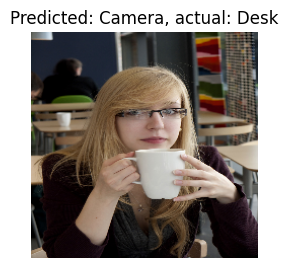

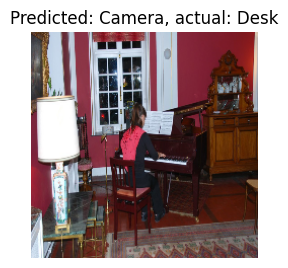

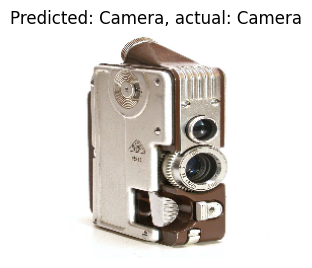

<Figure size 800x800 with 0 Axes>

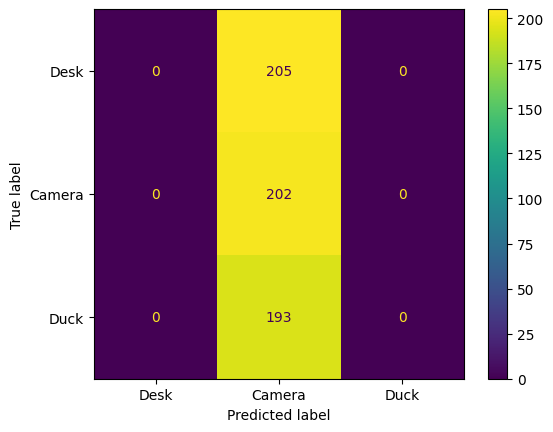

In [337]:
predictions_metrics(model1)

Threshold analysis with model 1, and best thresholds and f1scores for each class (desk, camera and duck respectively)

Working with batch  1  out of  10  ( batch size:  64 )
Working with batch  2  out of  10  ( batch size:  64 )
Working with batch  3  out of  10  ( batch size:  64 )
Working with batch  4  out of  10  ( batch size:  64 )
Working with batch  5  out of  10  ( batch size:  64 )
Working with batch  6  out of  10  ( batch size:  64 )
Working with batch  7  out of  10  ( batch size:  64 )
Working with batch  8  out of  10  ( batch size:  64 )
Working with batch  9  out of  10  ( batch size:  64 )
Working with batch  10  out of  10  ( batch size:  64 )
___________________________________________________________________________
Threshold analysis for class  Desk  – best f1score is  0.5093167701863354  with  0.0  threshold
___________________________________________________________________________


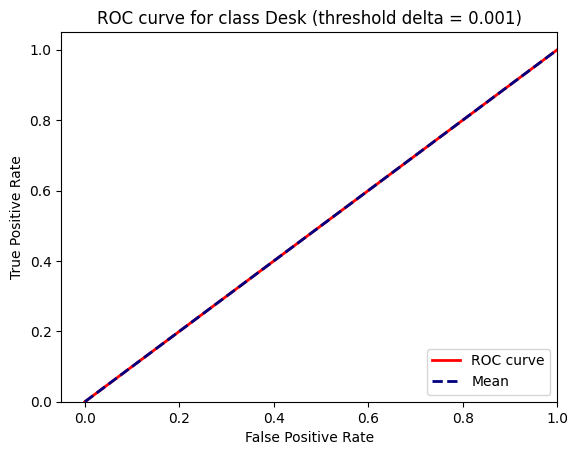

___________________________________________________________________________
Threshold analysis for class  Camera  – best f1score is  0.5037406483790524  with  0.0  threshold
___________________________________________________________________________


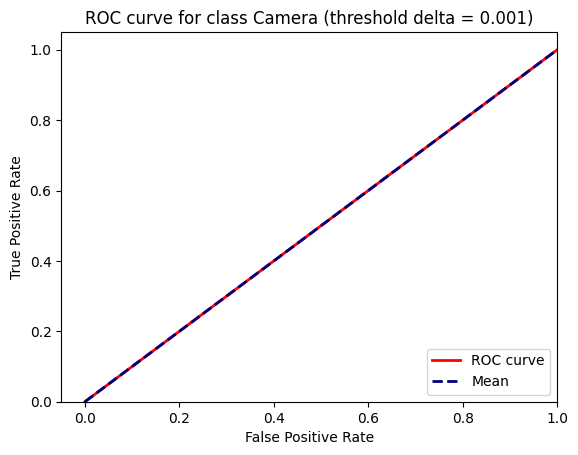

___________________________________________________________________________
Threshold analysis for class  Duck  – best f1score is  0.4867591424968474  with  0.0  threshold
___________________________________________________________________________


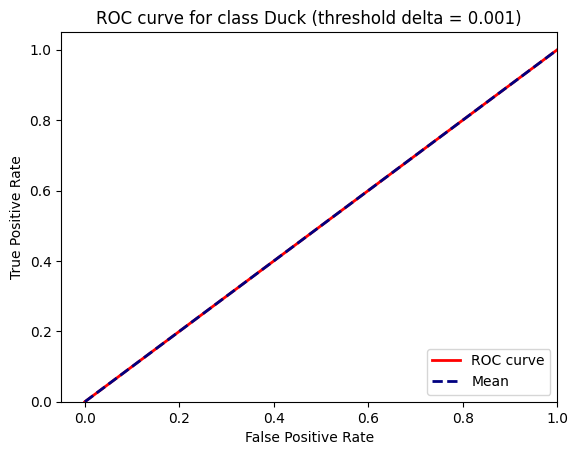

[0.0, 0.0, 0.0]
[0.5093167701863354, 0.5037406483790524, 0.4867591424968474]


In [338]:
predictions_threshold_analysis(model1)
print(best_thresholds)
print(best_f1scores)

Metrics for testing data with model 2

Working with batch  1  out of  10  ( batch size:  64 )
Working with batch  2  out of  10  ( batch size:  64 )
Working with batch  3  out of  10  ( batch size:  64 )
Working with batch  4  out of  10  ( batch size:  64 )
Working with batch  5  out of  10  ( batch size:  64 )
Working with batch  6  out of  10  ( batch size:  64 )
Working with batch  7  out of  10  ( batch size:  64 )
Working with batch  8  out of  10  ( batch size:  64 )
Working with batch  9  out of  10  ( batch size:  64 )
Working with batch  10  out of  10  ( batch size:  64 )
              precision    recall  f1-score   support

        Desk       0.63      0.33      0.43       205
      Camera       0.75      0.25      0.38       202
        Duck       0.44      0.96      0.60       193

    accuracy                           0.51       600
   macro avg       0.61      0.51      0.47       600
weighted avg       0.61      0.51      0.47       600



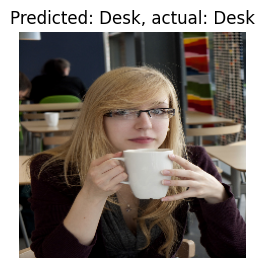

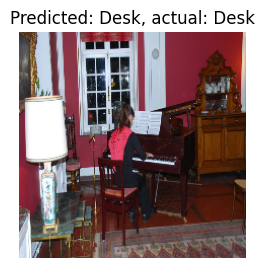

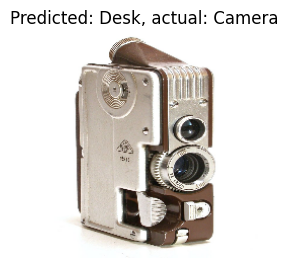

<Figure size 800x800 with 0 Axes>

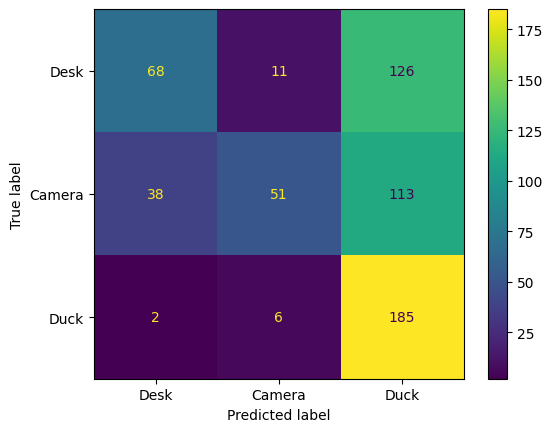

In [339]:
predictions_metrics(model2)

Threshold analysis with model 2, and best thresholds and f1scores for each class (desk, camera and duck respectively)

Working with batch  1  out of  10  ( batch size:  64 )
Working with batch  2  out of  10  ( batch size:  64 )
Working with batch  3  out of  10  ( batch size:  64 )
Working with batch  4  out of  10  ( batch size:  64 )
Working with batch  5  out of  10  ( batch size:  64 )
Working with batch  6  out of  10  ( batch size:  64 )
Working with batch  7  out of  10  ( batch size:  64 )
Working with batch  8  out of  10  ( batch size:  64 )
Working with batch  9  out of  10  ( batch size:  64 )
Working with batch  10  out of  10  ( batch size:  64 )
___________________________________________________________________________
Threshold analysis for class  Desk  – best f1score is  0.622792937399679  with  0.258  threshold
___________________________________________________________________________


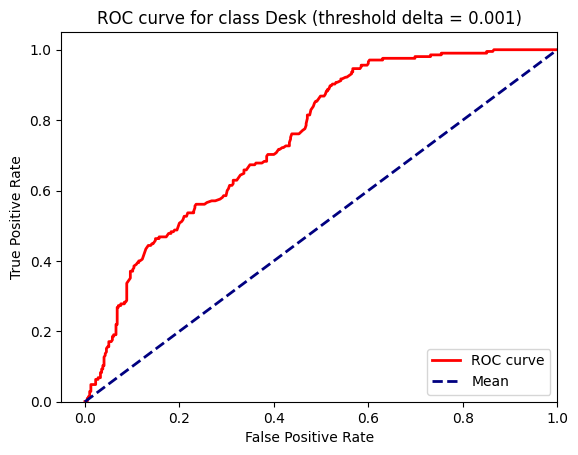

___________________________________________________________________________
Threshold analysis for class  Camera  – best f1score is  0.6537102473498234  with  0.1  threshold
___________________________________________________________________________


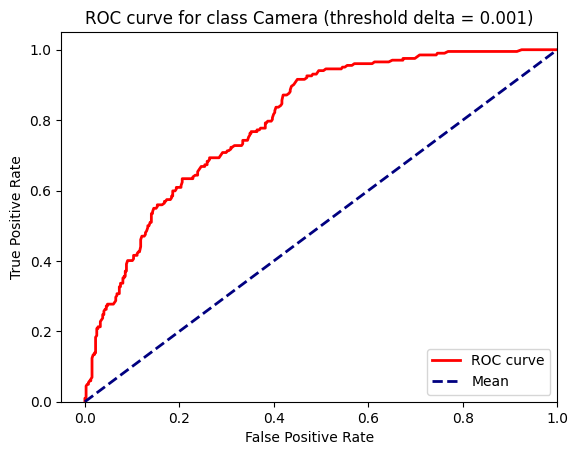

___________________________________________________________________________
Threshold analysis for class  Duck  – best f1score is  0.8206521739130436  with  0.862  threshold
___________________________________________________________________________


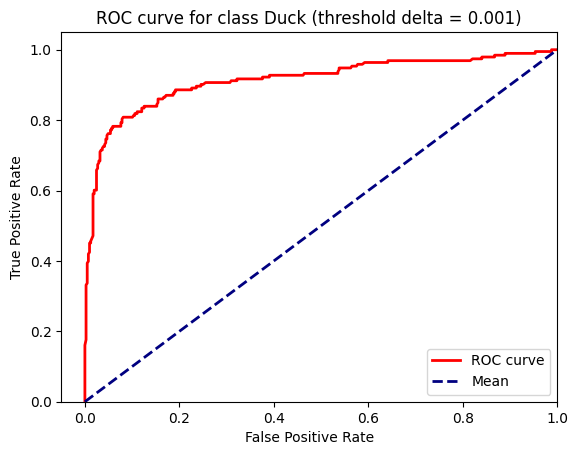

[0.258, 0.1, 0.862]
[0.622792937399679, 0.6537102473498234, 0.8206521739130436]


In [340]:
predictions_threshold_analysis(model2)
print(best_thresholds)
print(best_f1scores)

Metrics for testing data with model 3

Working with batch  1  out of  10  ( batch size:  64 )
Working with batch  2  out of  10  ( batch size:  64 )
Working with batch  3  out of  10  ( batch size:  64 )
Working with batch  4  out of  10  ( batch size:  64 )
Working with batch  5  out of  10  ( batch size:  64 )
Working with batch  6  out of  10  ( batch size:  64 )
Working with batch  7  out of  10  ( batch size:  64 )
Working with batch  8  out of  10  ( batch size:  64 )
Working with batch  9  out of  10  ( batch size:  64 )
Working with batch  10  out of  10  ( batch size:  64 )
              precision    recall  f1-score   support

        Desk       0.64      0.64      0.64       205
      Camera       0.63      0.56      0.59       202
        Duck       0.72      0.80      0.76       193

    accuracy                           0.67       600
   macro avg       0.66      0.67      0.67       600
weighted avg       0.66      0.67      0.66       600



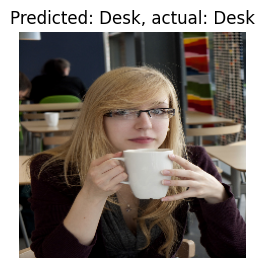

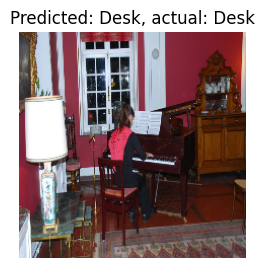

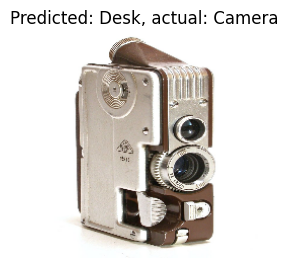

<Figure size 800x800 with 0 Axes>

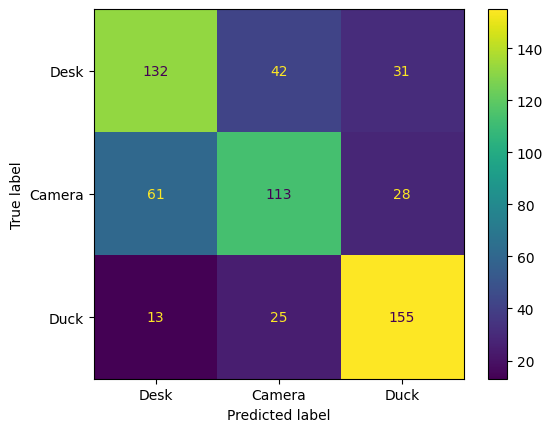

In [341]:
predictions_metrics(model3)

Threshold analysis with model 3, and best thresholds and f1scores for each class (desk, camera and duck respectively)

Working with batch  1  out of  10  ( batch size:  64 )
Working with batch  2  out of  10  ( batch size:  64 )
Working with batch  3  out of  10  ( batch size:  64 )
Working with batch  4  out of  10  ( batch size:  64 )
Working with batch  5  out of  10  ( batch size:  64 )
Working with batch  6  out of  10  ( batch size:  64 )
Working with batch  7  out of  10  ( batch size:  64 )
Working with batch  8  out of  10  ( batch size:  64 )
Working with batch  9  out of  10  ( batch size:  64 )
Working with batch  10  out of  10  ( batch size:  64 )
___________________________________________________________________________
Threshold analysis for class  Desk  – best f1score is  0.6654064272211719  with  0.268  threshold
___________________________________________________________________________


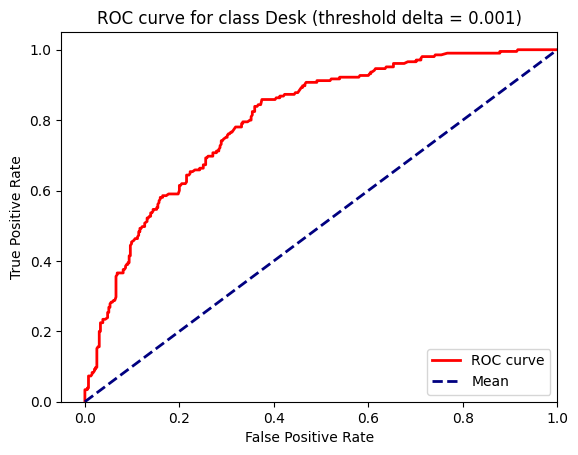

___________________________________________________________________________
Threshold analysis for class  Camera  – best f1score is  0.6142595978062158  with  0.261  threshold
___________________________________________________________________________


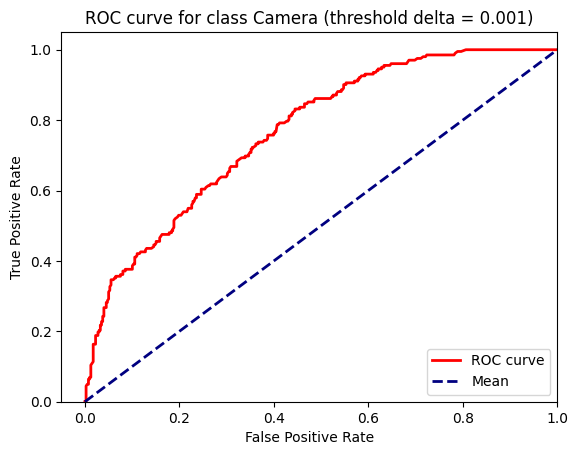

___________________________________________________________________________
Threshold analysis for class  Duck  – best f1score is  0.78125  with  0.545  threshold
___________________________________________________________________________


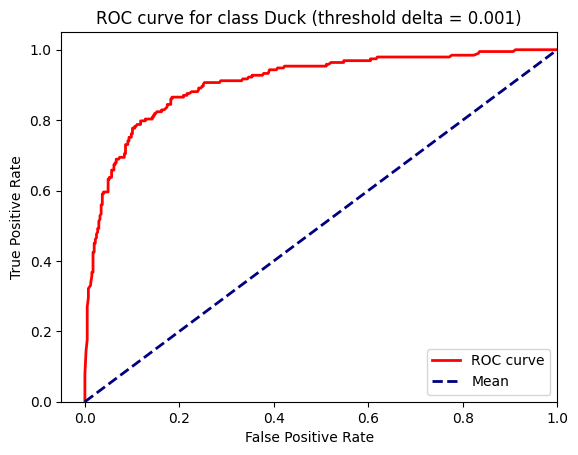

[0.268, 0.261, 0.545]
[0.6654064272211719, 0.6142595978062158, 0.78125]


In [342]:
predictions_threshold_analysis(model3)
print(best_thresholds)
print(best_f1scores)

Metrics for testing data with model 4

Working with batch  1  out of  10  ( batch size:  64 )
Working with batch  2  out of  10  ( batch size:  64 )
Working with batch  3  out of  10  ( batch size:  64 )
Working with batch  4  out of  10  ( batch size:  64 )
Working with batch  5  out of  10  ( batch size:  64 )
Working with batch  6  out of  10  ( batch size:  64 )
Working with batch  7  out of  10  ( batch size:  64 )
Working with batch  8  out of  10  ( batch size:  64 )
Working with batch  9  out of  10  ( batch size:  64 )
Working with batch  10  out of  10  ( batch size:  64 )
              precision    recall  f1-score   support

        Desk       0.77      0.59      0.66       205
      Camera       0.63      0.80      0.70       202
        Duck       0.91      0.89      0.90       193

    accuracy                           0.75       600
   macro avg       0.77      0.76      0.76       600
weighted avg       0.77      0.75      0.75       600



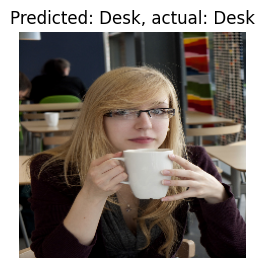

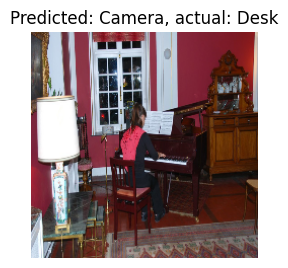

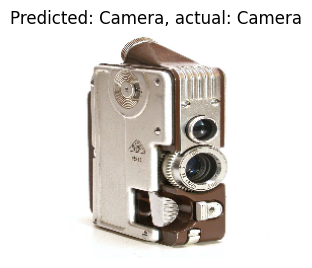

<Figure size 800x800 with 0 Axes>

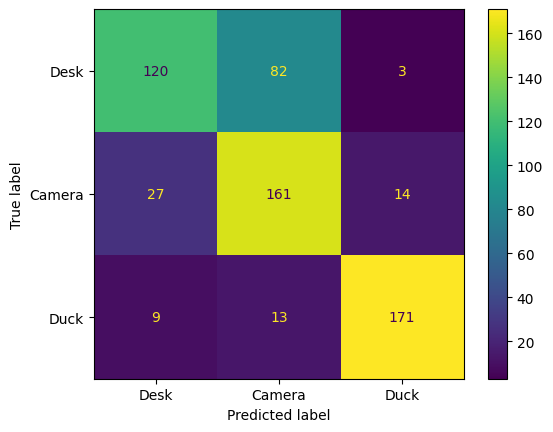

In [343]:
predictions_metrics(model4)

Threshold analysis with model 4, and best thresholds and f1scores for each class (desk, camera and duck respectively)

Working with batch  1  out of  10  ( batch size:  64 )
Working with batch  2  out of  10  ( batch size:  64 )
Working with batch  3  out of  10  ( batch size:  64 )
Working with batch  4  out of  10  ( batch size:  64 )
Working with batch  5  out of  10  ( batch size:  64 )
Working with batch  6  out of  10  ( batch size:  64 )
Working with batch  7  out of  10  ( batch size:  64 )
Working with batch  8  out of  10  ( batch size:  64 )
Working with batch  9  out of  10  ( batch size:  64 )
Working with batch  10  out of  10  ( batch size:  64 )
___________________________________________________________________________
Threshold analysis for class  Desk  – best f1score is  0.7621247113163974  with  0.309  threshold
___________________________________________________________________________


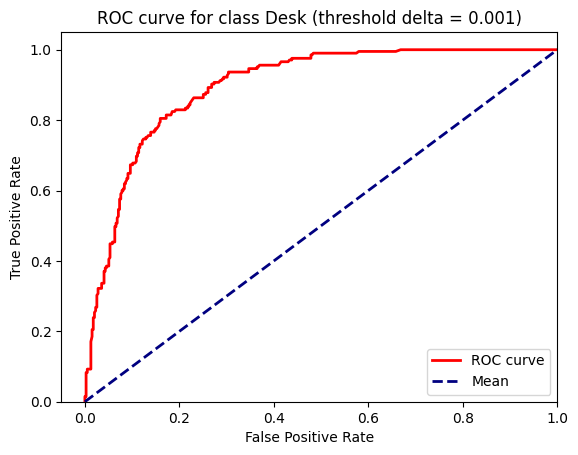

___________________________________________________________________________
Threshold analysis for class  Camera  – best f1score is  0.7168141592920354  with  0.457  threshold
___________________________________________________________________________


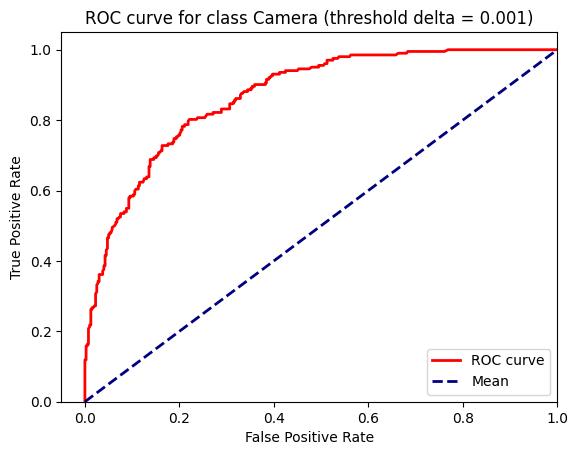

___________________________________________________________________________
Threshold analysis for class  Duck  – best f1score is  0.9048843187660668  with  0.352  threshold
___________________________________________________________________________


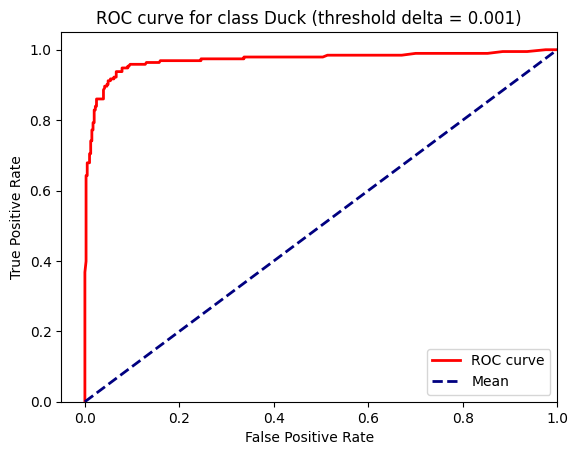

[0.309, 0.457, 0.352]
[0.7621247113163974, 0.7168141592920354, 0.9048843187660668]


In [344]:
predictions_threshold_analysis(model4)
print(best_thresholds)
print(best_f1scores)

Model 4 predictions for custom images (put images in task2CustomData folder.). Optimised with best thresholds for each class.

Scenarios covered:
*   One class in image
*   Two classes in image
*   No classes in image



Working with picture  1  out of  7
[0.4795051  0.50518835 0.02331576]
[1. 1. 0.]
Working with picture  2  out of  7
[0.02151464 0.9703755  0.00750057]
[0. 1. 0.]
Working with picture  3  out of  7
[0.12565346 0.87087953 0.00369055]
[0. 1. 0.]
Working with picture  4  out of  7
[2.9441039e-04 4.4503174e-04 9.9970871e-01]
[0. 0. 1.]
Working with picture  5  out of  7
[0.10552662 0.18689626 0.6821976 ]
[0. 0. 1.]
Working with picture  6  out of  7
[0.2830356  0.67978877 0.0333835 ]
[0. 1. 0.]
Working with picture  7  out of  7
[0.2595161  0.31341907 0.28423145]
[0. 0. 0.]


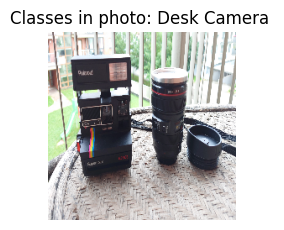

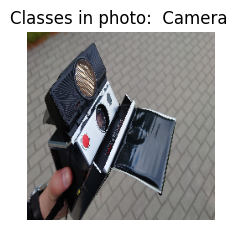

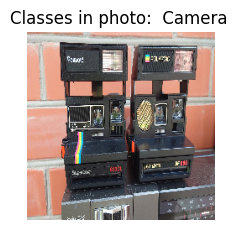

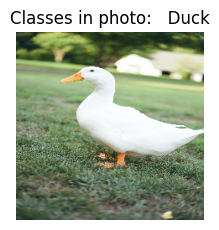

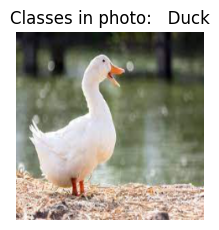

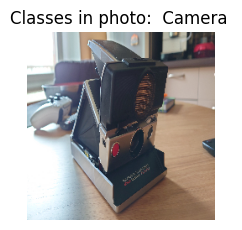

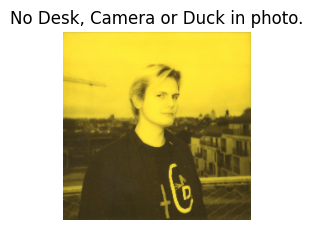

In [372]:
custom_data_directory = "task2CustomData"

custom_dataset = CustomDataset(custom_data_directory, custom=True)
custom_dataset_dataloader = torch.utils.data.DataLoader(custom_dataset, batch_size=1, shuffle=False, num_workers=2)
predicted_labels_custom = []
model4.eval()
with torch.inference_mode():
  
    for i, data in enumerate(custom_dataset_dataloader):
        print("Working with picture ", i+1, " out of ", len(custom_dataset_dataloader))
        data = data.to(device)
        output = model4(data).squeeze(0).sigmoid()
        preds = output.cpu().numpy()
        predicted_classes = np.array([preds[0],
                                      preds[1],
                                      preds[2]])

        c_predicted = np.array(predicted_classes)
        print(c_predicted)

        c_predicted[0] = c_predicted[0] > best_thresholds[0]
        c_predicted[1] = c_predicted[1] > best_thresholds[1]
        c_predicted[2] = c_predicted[2] > best_thresholds[2]
        print(c_predicted)
        fig = plt.figure(figsize=(25,20))
        ax = plt.subplot(len(custom_dataset_dataloader), 3, i+1)
        img = torch.tensor(data.cpu())
        im = img.squeeze().numpy().transpose((1, 2, 0))
        im = np.clip(im, 0, 1)
        plt.axis("off")
        if not any(c_predicted):
          ax.set_title("No {}, {} or {} in photo.".format(class_names[0], class_names[1], class_names[2]))
        if any(c_predicted):
          ax.set_title("Classes in photo: {} {} {}".format(class_names[0] if c_predicted[0] else "", class_names[1] if c_predicted[1] else "", class_names[2] if c_predicted[2] else ""))
        plt.imshow(im, cmap="gray")